## Imports

In [3]:
import numpy as np
import pandas as pd
from sklearn import model_selection
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from pandas import DataFrame
import pickle
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# RF
from sklearn.model_selection import cross_val_predict, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor

# Over-sampling for imbalance problem
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter

%config InlineBackend.figure_format = 'svg'

/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


## Pre-process data

In [74]:
os.chdir('/Users/hadi/Documents/Professional_development/DS/INSIGHT/Project/Data/Data_pro')
raw_data=pd.read_csv('Data_All_sorted_alpha_MVP_V8.csv')

#raw_data.index = raw_data.Neighbourhood

Y = pd.DataFrame(raw_data['Future_low_income_pop_per'])
Y=np.log(Y)
# Features selections

# options -: All fesstures:
# X = pd.DataFrame(raw_data[['Home price','Change in housing pricing','Low income population',\
#                          'Low income population percentage','Total Area','Total Population',\
#                          'Pop  25 - 34 years','Recent Immigrants','TTC Stops','Health Providers','Businesses',\
#                          'Social Housing Units','Rent Bank Applicants']])

# options -2: Selected features
X = pd.DataFrame(raw_data[['Low income population percentage','Total Area',\
                           'Recent Immigrants',\
                          'Social Housing Units', 'Pop  25 - 34 years']])

# Resampling for imbalance
#X_resampled, y_resampled = SMOTE().fit_resample(X, Y)
#print(sorted(Counter(y_resampled).items()))

#Split Test Train Data
    #if original data:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 42)

    #if resampled data:
#X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, y_resampled, test_size = 0.1, random_state = 44)


# #Method -2 : Stratified
# split = StratifiedShuffleSplit(n_splits=1, test_size=.15, random_state=44) # split is to classify for stratify
# for train_index, test_index in split.split(raw_data, raw_data[['Label']]):  # column to use to stratify
#     X_train = X.loc[train_index]
#     X_test = X.loc[test_index]
#     Y_train = Y.loc[train_index]
#     Y_test = Y.loc[test_index]

#Standardize the Data:
# scaler = StandardScaler().fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)


## Modeling

In [75]:
# Random Forest Modelling 

gsc = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid={
        'max_depth': range(10,12,14),
        'n_estimators': (50, 100, 200, 1000),
    }, cv=10, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

grid_result = gsc.fit(X_train, Y_train)
best_params = grid_result.best_params_
rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], random_state=False, verbose=False)
scores = cross_val_score(rfr, X_train, Y_train, cv=10, scoring='neg_mean_absolute_error')
print(scores)
model_RF=rfr.fit(X_train, Y_train)

# save the model to disk
predictive_Reg_model_RF = 'finalized_Reg_model_RF_NEW.sav'
pickle.dump(rfr, open(predictive_Reg_model_RF, 'wb'))

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed 

[-0.17734891 -0.18100994 -0.16016181 -0.16737448 -0.16503203 -0.20753732
 -0.17362054 -0.20199051 -0.21230005 -0.19391913]


## Predictions

In [77]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error

# load the model from disk
loaded_model = pickle.load(open('finalized_Reg_model_RF_NEW.sav', 'rb'))
model_RF = pickle.load(open('finalized_Reg_model_RF_NEW.sav', 'rb'))
y_pred_RF= loaded_model.predict(X_test)

y_pred_RF= loaded_model.predict(X_test)
y_pred_train_RF=loaded_model.predict(X_train)

Error = np.abs(Y_test.values - y_pred_RF)#/np.abs(Y_test)
print("Error : in "+str(np.mean(Error)))

rms_RFR = np.sqrt(mean_squared_error(Y_test, y_pred_RF))
print("RMS ="+str(rms_RFR))

rr_TRAIN = metrics.r2_score(Y_train, y_pred_train_RF)
rr_TRAIN = round(rr_TRAIN,2)
print("R-Squared-TRAIN ="+str(rr_TRAIN))

rr_TEST = metrics.r2_score(Y_test, y_pred_RF)
rr_TEST = round(rr_TEST,2)
print("R-Squared-TEST ="+str(rr_TEST))

Error : in 0.39397117456493885
RMS =0.18509398540280475
R-Squared-TRAIN =0.95
R-Squared-TEST =0.8


## Visualisation

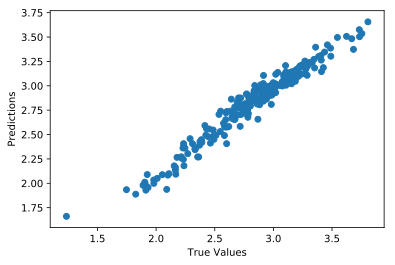

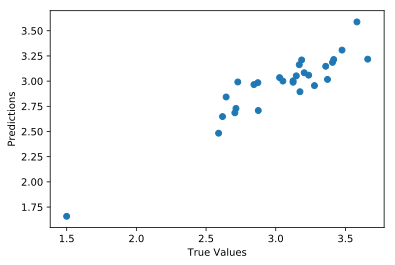

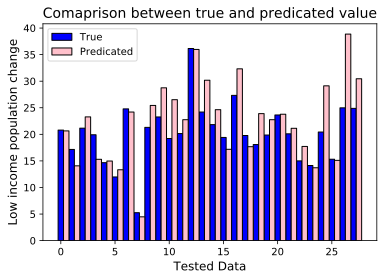

In [78]:
## The line / model
plt.scatter(Y_train, y_pred_train_RF)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.savefig('testplot.png')
plt.show()

plt.scatter(Y_test, y_pred_RF)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.savefig('testplot.png')
plt.show()

y_pred_RF_4plt = pd.DataFrame(np.exp(y_pred_RF))
y_pred_RF_4plt.columns = ['Future_low_income_pop_per']

y_test_4plt = pd.DataFrame(np.exp(Y_test))
#df['Future_change_low_income_pop'] = pd.DataFrame(y_pred_lm)
y_test_4plt.columns = ['Future_low_income_pop_per']


Coparison=['True','Predicated']
pos = np.arange(len(y_test_4plt))
bar_width = 0.5
PredictoinValues=y_pred_RF_4plt['Future_low_income_pop_per'] #[60,40,70,65,85,90,40,70,65,85,90,40,70,65,85,90,40,70,65,85,90,40,70,65,85,90,100,100]
TestValues=y_test_4plt['Future_low_income_pop_per'] #[30,60,70,55,75,90,60,70,55,75,90,60,70,55,75,90,60,70,55,75,90,60,70,55,75,90,20,33]


plt.bar(pos,PredictoinValues,bar_width,color='blue',edgecolor='black')
plt.bar(pos+bar_width,TestValues,bar_width,color='pink',edgecolor='black')
plt.xlabel('Tested Data', fontsize=12)
plt.ylabel('Low income population change', fontsize=12)
plt.title('Comaprison between true and predicated value',fontsize=14)
plt.legend(Coparison,loc=2)
plt.show()


In [79]:
best_params

{'max_depth': 10, 'n_estimators': 200}

## Plot Train and Test Data Together

Text(0.5, 1.0, 'Predicted Vs. Actual')

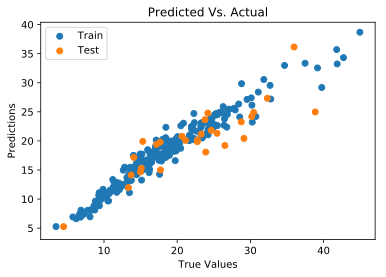

In [80]:
color = ("blue", "yellow")
plt.scatter(np.exp(Y_train), np.exp(y_pred_train_RF), label="Train")
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.savefig('testplot.png')

plt.scatter(np.exp(Y_test), np.exp(y_pred_RF), label="Test")
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.savefig('testplot.png')
plt.legend(loc=2)
plt.title('Predicted Vs. Actual')

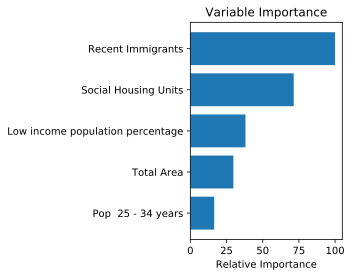

In [81]:
# Plot feature importance
feature_importance = model_RF.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()